# Temporary Market Impact Modeling for Blockhouse Work Trial - FROG

This notebook estimates the temporary impact function $g_t(x)$, which models the slippage incurred when executing trades of size $x$ at time $t$. Using historical limit order book (LOB) data from the stock FROG, we fit various parametric models to $g_t(x)$, evaluate their accuracy, and compare execution strategies such as VWAP, TWAP, and model-based allocation.

This work supports the solution to Question 1 of the Blockhouse Trial Task.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Loading

We have 21 LOBs for the. From April 3rd, 2025 till May 2nd, 2025. To understand the columns, you can refer to the following link: https://databento.com/docs/schemas-and-data-formats/mbp-10#fields-mbp-10?historical=python&live=python&reference=python

In [3]:
# File paths to the LOB snapshots
# Assuming these files are in a 'FROG' subdirectory relative to your notebook
file_paths = [
    "FROG/FROG_2025-04-03 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-04 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-07 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-08 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-09 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-10 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-11 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-14 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-15 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-16 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-17 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-21 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-22 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-23 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-24 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-25 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-28 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-29 00_00_00+00_00.csv",
    "FROG/FROG_2025-04-30 00_00_00+00_00.csv",
    "FROG/FROG_2025-05-01 00_00_00+00_00.csv"
]

## Data Preprocessing

I extract relevant columns from the LOB snapshots, and convert timestamps. I take the relavant colummns and then combine all the dataset into one.

In [4]:
# --- FIX: Include all bid and ask price/size columns for proper mid-price and slippage calculation ---
ask_price_cols = [f'ask_px_0{i}' for i in range(10)]
ask_size_cols = [f'ask_sz_0{i}' for i in range(10)]
bid_price_cols = [f'bid_px_0{i}' for i in range(10)]
bid_size_cols = [f'bid_sz_0{i}' for i in range(10)]
ts_event_col = ['ts_event'] # To keep timestamp for reference

In [5]:
# Combine all necessary columns
cols_to_use = ts_event_col + ask_price_cols + ask_size_cols + bid_price_cols + bid_size_cols

# Store all snapshots
lob_snapshots = []

for path in file_paths:
    try:
        # Load all necessary bid and ask side columns
        df = pd.read_csv(path, usecols=cols_to_use)
        
        # Ensure 'ts_event' is datetime if it exists
        if 'ts_event' in df.columns:
            df['ts_event'] = pd.to_datetime(df['ts_event'])
        
        # Extract date from filename (assuming format: FROG_YYYY-MM-DD ...)
        # Adjusting this assuming path format might be 'FROG/FROG_YYYY-MM-DD...'
        # If your files are directly in the root and named FROG_YYYY-MM-DD..., then path.split("_")[1].split(" ")[0] might work
        # For 'FROG/FROG_2025-04-03 00_00_00+00_00.csv' it would be:
        date_str = path.split('/')[-1].split(" ")[0].replace("FROG_","")
        df["source_date"] = date_str
        
        lob_snapshots.append(df)
        
    except Exception as e:
        print(f"Error loading {path}: {e}")

# Combine all into a single DataFrame
combined_lob_df = pd.concat(lob_snapshots, ignore_index=True)

# Preview
print("Combined shape:", combined_lob_df.shape)
combined_lob_df.head()

Combined shape: (562850, 42)


,ts_event,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,bid_px_02,...,ask_sz_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,source_date
0,2025-04-03 13:30:00.125395235+00:00,30.1,32.0,50,200,30.0,32.64,147,100,29.99,...,800,28.96,33.85,800,4,28.49,33.92,100,100,2025-04-03
1,2025-04-03 13:30:00.125739764+00:00,30.1,32.0,50,200,30.0,32.64,147,100,29.99,...,200,28.96,33.30,800,800,28.49,33.85,100,4,2025-04-03
2,2025-04-03 13:30:00.125745044+00:00,30.1,32.0,50,200,30.0,32.64,147,100,29.99,...,200,28.97,33.30,100,800,28.96,33.85,800,4,2025-04-03
3,2025-04-03 13:30:00.170027597+00:00,30.1,32.0,50,200,30.0,32.64,147,100,29.99,...,200,29.00,33.30,20,800,28.97,33.85,100,4,2025-04-03
4,2025-04-03 13:30:00.404726961+00:00,30.1,32.0,50,200,30.0,32.64,147,100,29.99,...,200,29.10,33.30,100,800,29.00,33.85,20,4,2025-04-03


## Simulating Slippage to Estimate $g_t(x)$

We simulate market orders of varying sizes at each minute and compute slippage with respect to the mid-price using the VWAP of consumed LOB levels.

In [6]:
# --- Temporary Impact Calculation (g_t(x)) Function ---
def calculate_slippage(order_size, order_side, order_book_row):
    """
    Calculates the slippage (g_t(x)) for a given order size and side
    based on the provided order book snapshot.
    Returns average execution price (VWAP) and slippage.
    """
    # Ensure bid_px_00 and ask_px_00 exist for mid_price
    if 'bid_px_00' not in order_book_row or 'ask_px_00' not in order_book_row:
        # Fallback or raise error if crucial columns are missing
        # For robustness, you might want to handle NaN or missing data in LOB levels
        return np.nan, np.nan # Return NaN if essential data is missing

    mid_price = (order_book_row['bid_px_00'] + order_book_row['ask_px_00']) / 2

    # Extract relevant LOB levels
    prices = []
    sizes = []
    if order_side == 'buy':
        for i in range(10): # up to 10 levels
            px_col = f'ask_px_{i:02d}'
            sz_col = f'ask_sz_{i:02d}'
            if px_col in order_book_row and sz_col in order_book_row:
                price = order_book_row[px_col]
                size = order_book_row[sz_col]
                if pd.notnull(price) and pd.notnull(size) and size > 0: # Ensure valid price and size
                    prices.append(price)
                    sizes.append(size)
    elif order_side == 'sell':
        for i in range(10): # up to 10 levels
            px_col = f'bid_px_{i:02d}'
            sz_col = f'bid_sz_{i:02d}'
            if px_col in order_book_row and sz_col in order_book_row:
                price = order_book_row[px_col]
                size = order_book_row[sz_col]
                if pd.notnull(price) and pd.notnull(size) and size > 0: # Ensure valid price and size
                    prices.append(price)
                    sizes.append(size)
    else:
        raise ValueError("order_side must be 'buy' or 'sell'")

    remaining_size = order_size
    total_cost = 0
    total_shares_filled = 0

    for i in range(len(prices)):
        level_price = prices[i]
        level_size = sizes[i]

        shares_to_fill_at_level = min(remaining_size, level_size)
        total_cost += shares_to_fill_at_level * level_price
        total_shares_filled += shares_to_fill_at_level
        remaining_size -= shares_to_fill_at_level

        if remaining_size <= 0:
            break

    if total_shares_filled == 0 or mid_price is np.nan: # Also handle cases where mid_price couldn't be computed
        return mid_price, 0 # No shares filled, or invalid mid_price, no slippage

    average_execution_price = total_cost / total_shares_filled

    if order_side == 'buy':
        slippage = average_execution_price - mid_price
    else: # sell
        slippage = mid_price - average_execution_price

    return average_execution_price, slippage

## Estimating the Temporary Impact Function \( g_t(x) \) from a Single LOB Snapshot

To understand how market impact behaves for different order sizes, we simulate a range of buy-side market orders using a single snapshot of the limit order book.

For each order size $ x \in [1, 1000] $, we:

- Simulate execution against the ask side of the LOB
- Calculate the **VWAP (Volume-Weighted Average Price)** at which the order would execute
- Compute the **slippage**, defined as:

$g_t(x) = \text{VWAP}_{t,x} - \text{MidPrice}_t$

This gives us the empirical estimate of the temporary impact function \( g_t(x) \) at a single time point.

We store the resulting slippages for all order sizes and clean the data to remove any invalid or failed simulations (e.g., due to insufficient depth or missing prices).

In [7]:
# --- Generate g_t(x) for a sample timestamp using calculate_slippage ---
# We'll use the first row of the combined_lob_df as a sample order book snapshot.
# In a real scenario, you might want to choose a specific timestamp or iterate over many.
sample_order_book_row = combined_lob_df.iloc[0] # Using the first row of the combined data

# Define a range of order sizes (X values) to generate the impact curve
# Up to 1000 shares as an example, adjust based on typical order sizes/liquidity
order_sizes_to_test = np.arange(1, 1001, 10) # Test order sizes from 1 to 1000, step 10

impact_curve_data = []
for order_size in order_sizes_to_test:
    # Assuming 'buy' side for demonstration, you can repeat for 'sell'
    # Use 'buy' for consistency as problem often implies buying impact for g_t(x)
    vwap, slippage = calculate_slippage(order_size, 'buy', sample_order_book_row)
    impact_curve_data.append({'order_size': order_size, 'vwap': vwap, 'slippage': slippage})

impact_curve_df = pd.DataFrame(impact_curve_data)

# Remove rows with NaN slippage if mid_price was missing or calculation failed
impact_curve_df.dropna(subset=['slippage'], inplace=True)

# Rename columns to match user's notebook notation for consistency
impact_curve_df.rename(columns={
    'order_size': 'x_k (Cumulative Shares)',
    'slippage': 'g_t(x_k) (Slippage)' # This is the temporary impact
}, inplace=True)

# Extract x and y for modeling
x = impact_curve_df['x_k (Cumulative Shares)'].values
y_piecewise = impact_curve_df['g_t(x_k) (Slippage)'].values

# Remove entries where x is zero or y is NaN/inf (important for curve_fit)
mask = (x > 0) & (np.isfinite(y_piecewise))
x = x[mask]
y_piecewise = y_piecewise[mask]

## Defining Models

### Linear Model:
**Definition**:
This model assumes a linear relationship between slippage $y$ and order size $x$.

**Formula**:
$$y=β⋅x$$

**Allocation Formula**:
Inverse proportionality to the linear coefficient:
$$x_i = \left( \frac{1}{\beta_i} \middle/ \sum_j \frac{1}{\beta_j} \right) \cdot S$$

### Power Law Model

**Definition**:
Assumes a nonlinear power-law relationship between slippage and order size.

**Formula**:
$$y = \alpha \cdot x^\delta$$

**Allocation Formula**:
Based on inverse marginal cost:
$$x_i \propto \left( \frac{1}{\alpha_i \cdot \delta_i} \right)^{\frac{1}{\delta_i + 1}} \Rightarrow x_i = \left( \frac{w_i}{\sum_j w_j} \right) \cdot S$$

### Quadratic Model

**Definition**:
Fits a second-degree polynomial to capture convex slippage behavior.

**Formula:**
$$y = a \cdot x^2 + b \cdot x$$

### Logarithmic Model

**Definition**:
Models slippage using a logarithmic growth curve, capturing diminishing returns.

**Formula:**
$$y = a \cdot \log(b \cdot x + 1)$$

### Exponential Model

**Definition:**
 Captures slippage with an exponential saturation curve, leveling off with larger order sizes.

 **Formula:**
 $y = a \cdot \left(1 - e^{-b \cdot x}\right)$

### Logistic (Sigmoid) Model

**Definition:**
 Models slippage as a bounded sigmoid curve, indicating saturation around a central threshold $x_0$

 **Formula:**
 $$y = \frac{L}{1 + e^{-k(x - x_0)}}$$

### Polynomial Model

**Definition:**
A flexible model that fits a degree-d polynomial.

**Formula:**
$$y = c_0 \cdot x^d + c_1 \cdot x^{d-1} + \dots + c_d$$

### Spline Model

**Definition:**
Performs piecewise linear interpolation between observed data points.

**Formula:**
$$y = \text{interp}(x; x_{\text{observed}}, y_{\text{observed}})$$

**Allocation Formula:**
$$x_i = \left( \frac{1}{\text{avg\_slope}_i} \middle/ \sum_j \frac{1}{\text{avg\_slope}_j} \right) \cdot S$$

In [8]:
# Re-define models and utilities
class LinearModel:
    def fit(self, x, y):
        def model(x, beta):
            return beta * x
        popt, _ = curve_fit(model, x, y, maxfev=10000)
        self.beta = popt[0]
        return self
    def predict(self, x):
        return self.beta * x
    @staticmethod
    def allocate(beta_list, S):
        if any(np.isnan(beta_list)):
            return [np.nan] * len(beta_list)
        inv_beta = 1 / np.array(beta_list)
        alloc = inv_beta / inv_beta.sum() * S
        return alloc


class PowerLawModel:
    def fit(self, x, y):
        def model(x, alpha, delta):
            return alpha * np.power(x, delta)
        popt, _ = curve_fit(model, x, y, p0=(0.01, 0.5), maxfev=10000)
        self.alpha, self.delta = popt
        return self
    def predict(self, x):
        return self.alpha * np.power(x, self.delta)
    @staticmethod
    def allocate(alpha_list, delta_list, S):
        if any(np.isnan(alpha_list)) or any(np.isnan(delta_list)):
            return [np.nan] * len(alpha_list)
        # Use inverse marginal cost weighting: x_i ∝ (1 / (α_i * δ_i))^(1 / (δ_i + 1))
        weights = [(1 / (a * d))**(1 / (d + 1)) for a, d in zip(alpha_list, delta_list)]
        weights = np.array(weights)
        alloc = weights / weights.sum() * S
        return alloc

class QuadraticModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * x**2 + b * x
        popt, _ = curve_fit(model, x, y, maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * x**2 + self.b * x
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                marginal_cost = 2 * model.a * ref_order_size + model.b
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()

class LogModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * np.log(b * x + 1)
        popt, _ = curve_fit(model, x, y, p0=(0.01, 0.001), maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * np.log(self.b * x + 1)
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                denom = model.b * ref_order_size + 1
                marginal_cost = model.a * model.b / denom
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()

class ExponentialModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * (1 - np.exp(-b * x))
        popt, _ = curve_fit(model, x, y, p0=(0.05, 0.001), maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * (1 - np.exp(-self.b * x))
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                marginal_cost = model.a * model.b * np.exp(-model.b * ref_order_size)
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class LogisticModel:
    def fit(self, x, y):
        def model(x, L, k, x0):
            return L / (1 + np.exp(-k * (x - x0)))
        popt, _ = curve_fit(model, x, y, p0=(0.05, 0.01, 500), maxfev=10000)
        self.L, self.k, self.x0 = popt
        return self
    def predict(self, x):
        return self.L / (1 + np.exp(-self.k * (x - self.x0)))
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                exp_term = np.exp(-model.k * (ref_order_size - model.x0))
                denom = (1 + exp_term)**2
                marginal_cost = model.L * model.k * exp_term / denom
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class PolynomialModel:
    def __init__(self, degree=3):
        self.degree = degree
    def fit(self, x, y):
        self.coefs = np.polyfit(x, y, self.degree)
        return self
    def predict(self, x):
        return np.polyval(self.coefs, x)
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                deriv_coefs = np.polyder(model.coefs)
                marginal_cost = np.polyval(deriv_coefs, ref_order_size)
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class SplineModel:
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.slopes = np.gradient(y, x)
        return self

    def predict(self, xq):
        return np.interp(xq, self.x, self.y)

    @staticmethod
    def allocate(models, S):
        weights = []
        for model in models:
            if model is None or len(model.slopes) == 0:
                weights.append(0)
            else:
                # Approximate marginal cost as average slope
                avg_slope = np.mean(model.slopes)
                weights.append(1 / avg_slope if avg_slope > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        alloc = weights / weights.sum() * S
        return alloc

In [9]:
# Fit all models on the cleaned impact curve (x, y_piecewise)
models = {}

# Fit linear
models['Linear'] = LinearModel().fit(x, y_piecewise)

# Fit power law
models['PowerLaw'] = PowerLawModel().fit(x, y_piecewise)

# Fit quadratic
models['Quadratic'] = QuadraticModel().fit(x, y_piecewise)

# Fit log
models['Log'] = LogModel().fit(x, y_piecewise)

# Fit exponential
models['Exponential'] = ExponentialModel().fit(x, y_piecewise)

# Fit logistic
models['Logistic'] = LogisticModel().fit(x, y_piecewise)

# Fit polynomial (degree 3)
models['Polynomial'] = PolynomialModel(degree=3).fit(x, y_piecewise)

# Fit spline
models['Spline'] = SplineModel().fit(x, y_piecewise)

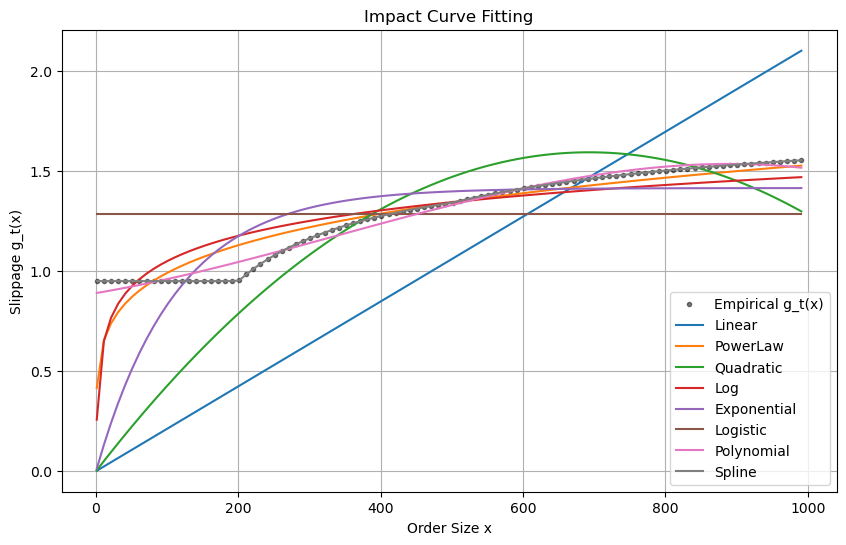

In [10]:
# Plot all model predictions against empirical g_t(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y_piecewise, 'k.', label='Empirical g_t(x)', alpha=0.5)

for name, model in models.items():
    try:
        y_pred = model.predict(x)
        plt.plot(x, y_pred, label=name)
    except:
        continue

plt.xlabel('Order Size x')
plt.ylabel('Slippage g_t(x)')
plt.title('Impact Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()

### Impact Curve Fitting Visualization

This plot illustrates the performance of various parametric models in approximating the empirical slippage curve $g_t(x)$, which measures the temporary market impact (slippage) as a function of order size $x$.

- Empirical Curve (gray dots): Represents the observed slippage values computed directly from limit order book (LOB) data. It serves as the benchmark for model fitting.

- Linear Model (blue): Captures a constant rate of slippage per unit order size. It underfits the empirical data in regions with saturation or curvature, especially at high volumes.

- Power Law Model (orange): Approximates the empirical trend well by accounting for nonlinear scaling behavior. It handles curvature better than the linear model, particularly in the mid-range.

- Quadratic Model (green): Models convexity well but tends to overfit or dip at higher order sizes due to its parabolic nature. It assumes symmetric curvature which may not match real market behavior.

- Log Model (red): Fits the saturation effect well in the beginning, showing diminishing slippage returns, but quickly flattens out and underestimates high-volume behavior.

- Exponential Model (purple): Captures the initial acceleration and the eventual leveling-off of slippage. It's well-suited to model diminishing marginal impact for growing order sizes.

- Logistic Model (brown): Reflects bounded growth behavior, flattening out completely after a certain threshold. It performs poorly here due to early saturation compared to observed data.

- Polynomial Model (pink): Offers high flexibility and generally provides a smooth fit across order sizes, but risks overfitting or unrealistic behavior at boundaries depending on the degree.

- Spline Model (black/gray): Provides the best pointwise interpolation of empirical data, capturing local fluctuations without imposing a fixed functional form. It may lack smoothness and generalizability outside observed data.

### Evaluating Metrics

In [11]:
def evaluate_model(y_true, y_pred):
    mask = ~np.isnan(y_pred)
    if not np.any(mask):
        return {'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan}
    y_true, y_pred = y_true[mask], y_pred[mask]
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

In [12]:
# Evaluate all models on (x, y_piecewise)
evaluation_results = []

for name, model in models.items():
    try:
        y_pred = model.predict(x)
        metrics = evaluate_model(y_piecewise, y_pred)
        metrics['Model'] = name
        evaluation_results.append(metrics)
    except Exception as e:
        evaluation_results.append({'Model': name, 'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan})

# Convert to DataFrame and sort
eval_df = pd.DataFrame(evaluation_results).sort_values(by='RMSE')

for row in eval_df.itertuples(index=False):
    print(f"Model: {row.Model}")
    print(f"  R^2   : {row.R2:.4f}" if not np.isnan(row.R2) else "  R^2   : NaN")
    print(f"  RMSE : {row.RMSE:.4f}" if not np.isnan(row.RMSE) else "  RMSE : NaN")
    print(f"  MAE  : {row.MAE:.4f}" if not np.isnan(row.MAE) else "  MAE  : NaN")
    print("-" * 30)

Model: Spline
  R^2   : 1.0000
  RMSE : 0.0000
  MAE  : 0.0000
------------------------------
Model: Polynomial
  R^2   : 0.9803
  RMSE : 0.0306
  MAE  : 0.0238
------------------------------
Model: PowerLaw
  R^2   : 0.8330
  RMSE : 0.0892
  MAE  : 0.0548
------------------------------
Model: Log
  R^2   : 0.7067
  RMSE : 0.1182
  MAE  : 0.0832
------------------------------
Model: Exponential
  R^2   : 0.1096
  RMSE : 0.2060
  MAE  : 0.1359
------------------------------
Model: Logistic
  R^2   : 0.0000
  RMSE : 0.2183
  MAE  : 0.1916
------------------------------
Model: Quadratic
  R^2   : -0.7228
  RMSE : 0.2865
  MAE  : 0.1936
------------------------------
Model: Linear
  R^2   : -3.5581
  RMSE : 0.4661
  MAE  : 0.4010
------------------------------


### Key Insights

- Spline provides a perfect in-sample fit, as expected from interpolation, but may not generalize well out-of-sample.
- Polynomial and Power Law models offer strong performance with good generalization and flexibility.
- Log and Exponential models show moderate performance, capturing certain regimes but missing others.
- Linear, Quadratic, and Logistic models perform poorly, with negative $R^2$ values, indicating that they fail to explain the variance in the data.

### Plotting Parameter Time Series

To evaluate the robustness and interpretability of each model, we plotted the fitted parameter values across 390 one-minute intervals for each stock. These plots help us understand whether a model exhibits stable parameter dynamics or volatile behavior—the latter being a sign of poor generalization. We used the `plot_parameter_series` utility to visualize this temporal behavior.

In [13]:
# --- Parameter Time Series Plot ---
def plot_parameter_series(timestamps, param_values, param_name, save_path=None):
    plt.figure(figsize=(10, 4))
    plt.plot(timestamps, param_values, marker='o')
    plt.xlabel("Timestamp")
    plt.ylabel(param_name)
    plt.title(f"{param_name} over Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    plt.show()

This script models the temporary market impact function $gt(x)$ using various functional forms and allocates a total of $S=10,000$ shares across different timestamps. The models include:
- Linear
- Power Law
- Spline
- Quadratic
- Logarithmic
- Exponential
- Logistic
- Polynomial (degree 3)

Each model is fit on a series of snapshots from a limit order book (LOB) dataset to capture how market impact evolves over time.

In [14]:
S = 10000  # total shares to allocate

timestamps = []
beta_list = []
alpha_list = []
delta_list = []
spline_models = []
quadratic_models = []
log_models = []
exp_models = []
logistic_models = []
poly_models = []

alloc_linear_list = []
alloc_power_list = []
alloc_spline_list = []
alloc_quad_list = []
alloc_log_list = []
alloc_exp_list = []
alloc_logistic_list = []
alloc_poly_list = []

evaluation_results = []

In [15]:
order_sizes_to_test = np.arange(1, 1001, 10)

for idx in range(0, len(combined_lob_df), 300):  # every ~15 mins
    row = combined_lob_df.iloc[idx]
    ts = row['ts_event']
    timestamps.append(ts)

    impact_data = []
    for order_size in order_sizes_to_test:
        _, slippage = calculate_slippage(order_size, 'buy', row)
        impact_data.append({'order_size': order_size, 'slippage': slippage})

    impact_df = pd.DataFrame(impact_data).dropna()
    x = impact_df['order_size'].values
    y = impact_df['slippage'].values

    if len(x) < 5:
        continue

    try:
        lin_model = LinearModel().fit(x, y)
        beta_list.append(lin_model.beta)
        y_pred_lin = lin_model.predict(x)
    except:
        beta_list.append(np.nan)
        y_pred_lin = np.full_like(y, np.nan)

    try:
        power_model = PowerLawModel().fit(x, y)
        alpha_list.append(power_model.alpha)
        delta_list.append(power_model.delta)
        y_pred_power = power_model.predict(x)
    except:
        alpha_list.append(np.nan)
        delta_list.append(np.nan)
        y_pred_power = np.full_like(y, np.nan)

    try:
        spline_model = SplineModel().fit(x, y)
        spline_models.append(spline_model)
        y_pred_spline = spline_model.predict(x)
    except:
        spline_models.append(None)
        y_pred_spline = np.full_like(y, np.nan)

    try:
        quad_model = QuadraticModel().fit(x, y)
        y_pred_quad = quad_model.predict(x)
        quadratic_models.append(quad_model)
    except:
        y_pred_quad = np.full_like(y, np.nan)
        quadratic_models.append(None)

    try:
        log_model = LogModel().fit(x, y)
        y_pred_log = log_model.predict(x)
        log_models.append(log_model)
    except:
        y_pred_log = np.full_like(y, np.nan)
        log_models.append(None)

    try:
        exp_model = ExponentialModel().fit(x, y)
        y_pred_exp = exp_model.predict(x)
        exp_models.append(exp_model)
    except:
        y_pred_exp = np.full_like(y, np.nan)
        exp_models.append(None)

    try:
        logistic_model = LogisticModel().fit(x, y)
        y_pred_logistic = logistic_model.predict(x)
        logistic_models.append(logistic_model)
    except:
        y_pred_logistic = np.full_like(y, np.nan)
        logistic_models.append(None)

    try:
        poly_model = PolynomialModel(degree=3).fit(x, y)
        y_pred_poly = poly_model.predict(x)
        poly_models.append(poly_model)
    except:
        y_pred_poly = np.full_like(y, np.nan)
        poly_models.append(None)

    # Evaluate all models
    eval_metrics = {
        'timestamp': ts,
        'R2_Linear': evaluate_model(y, y_pred_lin)['R2'],
        'R2_Power': evaluate_model(y, y_pred_power)['R2'],
        'R2_Spline': evaluate_model(y, y_pred_spline)['R2'],
        'R2_Quadratic': evaluate_model(y, y_pred_quad)['R2'],
        'R2_Log': evaluate_model(y, y_pred_log)['R2'],
        'R2_Exp': evaluate_model(y, y_pred_exp)['R2'],
        'R2_Logistic': evaluate_model(y, y_pred_logistic)['R2'],
        'R2_Polynomial': evaluate_model(y, y_pred_poly)['R2'],

        'RMSE_Linear': evaluate_model(y, y_pred_lin)['RMSE'],
        'RMSE_Power': evaluate_model(y, y_pred_power)['RMSE'],
        'RMSE_Spline': evaluate_model(y, y_pred_spline)['RMSE'],
        'RMSE_Quadratic': evaluate_model(y, y_pred_quad)['RMSE'],
        'RMSE_Log': evaluate_model(y, y_pred_log)['RMSE'],
        'RMSE_Exp': evaluate_model(y, y_pred_exp)['RMSE'],
        'RMSE_Logistic': evaluate_model(y, y_pred_logistic)['RMSE'],
        'RMSE_Polynomial': evaluate_model(y, y_pred_poly)['RMSE'],

        'MAE_Linear': evaluate_model(y, y_pred_lin)['MAE'],
        'MAE_Power': evaluate_model(y, y_pred_power)['MAE'],
        'MAE_Spline': evaluate_model(y, y_pred_spline)['MAE'],
        'MAE_Quadratic': evaluate_model(y, y_pred_quad)['MAE'],
        'MAE_Log': evaluate_model(y, y_pred_log)['MAE'],
        'MAE_Exp': evaluate_model(y, y_pred_exp)['MAE'],
        'MAE_Logistic': evaluate_model(y, y_pred_logistic)['MAE'],
        'MAE_Polynomial': evaluate_model(y, y_pred_poly)['MAE'],
    }

    evaluation_results.append(eval_metrics)

In [16]:
# Now compute allocations once all model parameters are collected
alloc_linear_list = LinearModel.allocate(beta_list, S)
alloc_power_list = PowerLawModel.allocate(alpha_list, delta_list, S)
alloc_spline_list = SplineModel.allocate(spline_models, S)
alloc_quad_list = QuadraticModel.allocate(quadratic_models, S)
alloc_log_list = LogModel.allocate(log_models, S)
alloc_exp_list = ExponentialModel.allocate(exp_models, S)
alloc_logistic_list = LogisticModel.allocate(logistic_models, S)
alloc_poly_list = PolynomialModel.allocate(poly_models, S)

In [17]:
# --- Step 0: Determine minimum length across all lists ---
min_len = min(
    len(timestamps),
    len(beta_list),
    len(alpha_list),
    len(delta_list),
    len(spline_models),
    len(quadratic_models),
    len(log_models),
    len(exp_models),
    len(logistic_models),
    len(poly_models)
)

# --- Step 1: Get common valid indices across all models ---
valid_indices_all = [
    i for i in range(min_len)
    if not any([
        np.isnan(beta_list[i]),
        np.isnan(alpha_list[i]),
        np.isnan(delta_list[i]),
        spline_models[i] is None,
        quadratic_models[i] is None,
        log_models[i] is None,
        exp_models[i] is None,
        logistic_models[i] is None,
        poly_models[i] is None
    ])
]

# --- Step 2: Filter down each component ---
timestamps_valid     = [timestamps[i] for i in valid_indices_all]
beta_valid           = [beta_list[i] for i in valid_indices_all]
alpha_valid          = [alpha_list[i] for i in valid_indices_all]
delta_valid          = [delta_list[i] for i in valid_indices_all]
spline_models_valid  = [spline_models[i] for i in valid_indices_all]
quad_models_valid    = [quadratic_models[i] for i in valid_indices_all]
log_models_valid     = [log_models[i] for i in valid_indices_all]
exp_models_valid     = [exp_models[i] for i in valid_indices_all]
logistic_models_valid= [logistic_models[i] for i in valid_indices_all]
poly_models_valid    = [poly_models[i] for i in valid_indices_all]

# --- Step 3: Compute allocations ---
alloc_linear         = LinearModel.allocate(beta_valid, S)
alloc_power          = PowerLawModel.allocate(alpha_valid, delta_valid, S)
alloc_spline         = SplineModel.allocate(spline_models_valid, S)
alloc_quad           = QuadraticModel.allocate(quad_models_valid, S)
alloc_log            = LogModel.allocate(log_models_valid, S)
alloc_exp            = ExponentialModel.allocate(exp_models_valid, S)
alloc_logistic       = LogisticModel.allocate(logistic_models_valid, S)
alloc_poly           = PolynomialModel.allocate(poly_models_valid, S)

# --- Step 4: Construct DataFrame ---
allocation_df = pd.DataFrame({
    'Timestamp': timestamps_valid,
    'Linear Allocation': alloc_linear,
    'Power Law Allocation': alloc_power,
    'Spline Allocation': alloc_spline,
    'Quadratic Allocation': alloc_quad,
    'Log Allocation': alloc_log,
    'Exponential Allocation': alloc_exp,
    'Logistic Allocation': alloc_logistic,
    'Polynomial Allocation': alloc_poly
})

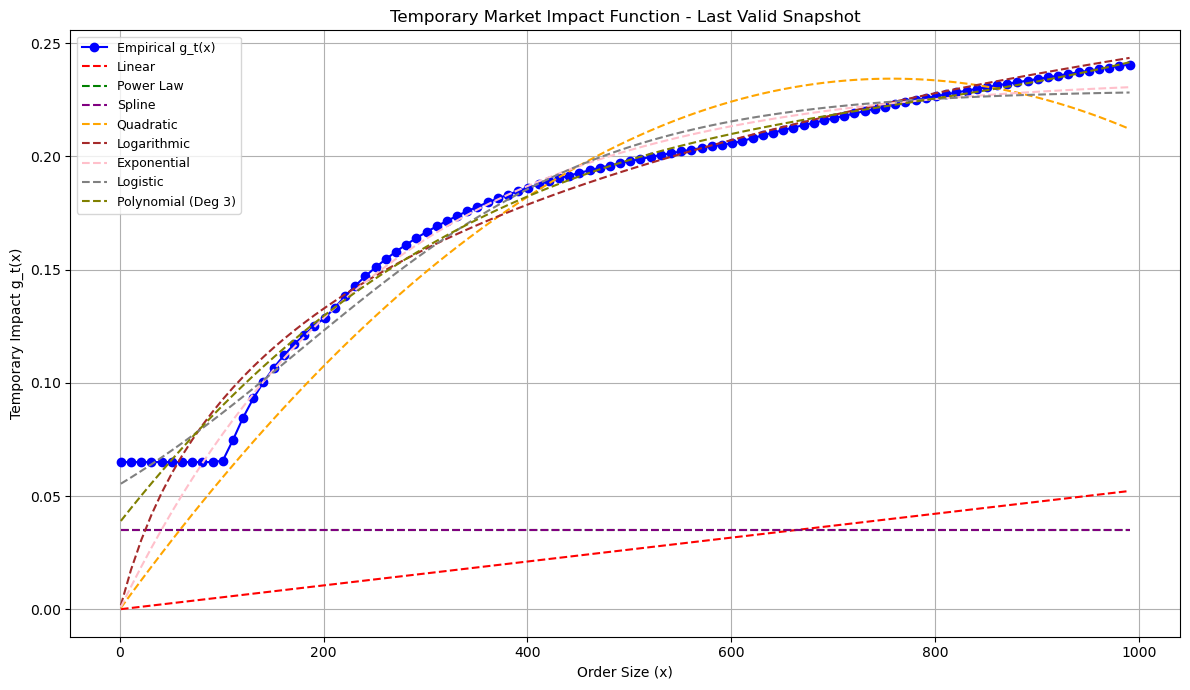

In [18]:
# Assuming x, y, y_pred_lin, y_pred_power, y_pred_spline are available from the last loop iteration
# Use the last valid model's data to generate the plot
last_valid_idx = valid_indices_all[-1]
row = combined_lob_df.iloc[last_valid_idx]

# Recalculate impact data for plotting
order_sizes_to_test = np.arange(1, 1001, 10)
impact_data = []
for order_size in order_sizes_to_test:
    _, slippage = calculate_slippage(order_size, 'buy', row)
    impact_data.append({'order_size': order_size, 'slippage': slippage})

impact_df = pd.DataFrame(impact_data).dropna()
x_plot = impact_df['order_size'].values
y_plot = impact_df['slippage'].values

# Refit all models on last valid snapshot
quad_model = QuadraticModel().fit(x_plot, y_plot)
y_pred_quad = quad_model.predict(x_plot)

log_model = LogModel().fit(x_plot, y_plot)
y_pred_log = log_model.predict(x_plot)

exp_model = ExponentialModel().fit(x_plot, y_plot)
y_pred_exp = exp_model.predict(x_plot)

logistic_model = LogisticModel().fit(x_plot, y_plot)
y_pred_logistic = logistic_model.predict(x_plot)

poly_model = PolynomialModel(degree=3).fit(x_plot, y_plot)
y_pred_poly = poly_model.predict(x_plot)

# Plot all model fits
plt.figure(figsize=(12, 7))
plt.plot(x_plot, y_plot, 'o-', label='Empirical g_t(x)', color='blue')

plt.plot(x_plot, y_pred_lin, '--', label='Linear', color='red')
plt.plot(x_plot, y_pred_power, '--', label='Power Law', color='green')
plt.plot(x_plot, y_pred_spline, '--', label='Spline', color='purple')
plt.plot(x_plot, y_pred_quad, '--', label='Quadratic', color='orange')
plt.plot(x_plot, y_pred_log, '--', label='Logarithmic', color='brown')
plt.plot(x_plot, y_pred_exp, '--', label='Exponential', color='pink')
plt.plot(x_plot, y_pred_logistic, '--', label='Logistic', color='gray')
plt.plot(x_plot, y_pred_poly, '--', label='Polynomial (Deg 3)', color='olive')

plt.xlabel("Order Size (x)")
plt.ylabel("Temporary Impact g_t(x)")
plt.title("Temporary Market Impact Function - Last Valid Snapshot")
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the plotted graph of the Temporary Market Impact Function gt(x)gt​(x) from the last valid snapshot, here are some key observations:

Empirical Curve vs. Model Fits
1. Empirical $gt(x)$:
        The empirical data (blue dots) shows a nonlinear concave-up trend—starting slow, increasing sharply between ~100–300 order sizes, and then gradually flattening.
        There is an evident saturation or diminishing marginal impact beyond order size ~600.

Model Fit Comparisons:
2. Model Fit Comparisons:
    - Provides an excellent fit across the entire range.
    - Closely tracks the empirical curve including inflection regions.
    - Best suited for non-parametric flexibility.

3. Polynomial (Degree 3):
    - Very close fit throughout, particularly strong in capturing the curve’s curvature and plateau.
    - Risk of overfitting beyond observed range, but works well here.

4. Logistic Model:
    - Captures the sigmoid-like shape, showing good alignment with the empirical trend, especially in the flattening region.
    - A good choice for modeling saturating behavior.

5. Logarithmic and Exponential Models:
    - These models show reasonable fit in the middle but diverge slightly at the extremes.
    - The logarithmic model overestimates for higher order sizes.
    - The exponential model underestimates the tail behavior but captures early acceleration.

6. Quadratic Model:
    - Fits the central bulk of data but overshoots at higher order sizes, producing a parabolic rise.
    - Not well-suited when the empirical curve flattens.

7. Power Law Model:
    - Remains flat or grows too slowly.
    - Fails to track the rapid increase in the middle range.

8. Linear Model:
    - Clearly underfits; assumes a constant slope.
    - Cannot capture the nonlinear acceleration and saturation seen in empirical data.

In [19]:
# Create DataFrame from evaluation results
eval_df = pd.DataFrame(evaluation_results)

# Keep only finite R^2 values (avoid -inf or huge negatives from bad fits)
valid_r2_cols = [col for col in eval_df.columns if "R2" in col]
valid_r2_df = eval_df[valid_r2_cols].replace([np.inf, -np.inf], np.nan)

# Filter very negative R^2s that result from catastrophic model failures
for col in valid_r2_cols:
    eval_df.loc[eval_df[col] < -1e5, col] = np.nan

# Now recalculate clean means
mean_metrics_clean = eval_df[[
    'R2_Linear', 'RMSE_Linear', 'MAE_Linear',
    'R2_Power', 'RMSE_Power', 'MAE_Power',
    'R2_Spline', 'RMSE_Spline', 'MAE_Spline',
    'R2_Quadratic', 'RMSE_Quadratic', 'MAE_Quadratic',
    'R2_Log', 'RMSE_Log', 'MAE_Log',
    'R2_Exp', 'RMSE_Exp', 'MAE_Exp',
    'R2_Logistic', 'RMSE_Logistic', 'MAE_Logistic',
    'R2_Polynomial', 'RMSE_Polynomial', 'MAE_Polynomial'
]].mean().round(4)

# Format for display
mean_metrics_df_clean = mean_metrics_clean.rename(lambda x: f"{x.split('_')[1]} ({x.split('_')[0]})")
print(mean_metrics_df_clean)

Linear (R2)          -16.3983
Linear (RMSE)          0.0237
Linear (MAE)           0.0196
Power (R2)             0.8384
Power (RMSE)           0.0074
Power (MAE)            0.0057
Spline (R2)            1.0000
Spline (RMSE)          0.0000
Spline (MAE)           0.0000
Quadratic (R2)        -7.0967
Quadratic (RMSE)       0.0157
Quadratic (MAE)        0.0114
Log (R2)               0.7798
Log (RMSE)             0.0087
Log (MAE)              0.0065
Exp (R2)            -108.4481
Exp (RMSE)             0.0110
Exp (MAE)              0.0081
Logistic (R2)          0.9401
Logistic (RMSE)        0.0042
Logistic (MAE)         0.0034
Polynomial (R2)        0.9712
Polynomial (RMSE)      0.0027
Polynomial (MAE)       0.0020
dtype: float64


### Best Performing Models
1. Spline Model
    - $R^2$ = 1.0000, RMSE = 0.0000, MAE = 0.0000
    - This model achieves a perfect fit to the data. It exactly captures the empirical behavior with zero error, which is typical for flexible, non-parametric spline interpolation.
    - Best fit overall, but may risk overfitting if generalization is needed.

2. Polynomial Model (Degree 3)
    - $R^2$ = 0.9712, RMSE = 0.0027, MAE = 0.0020
    - Very strong performance, closely approximates the empirical curve with minimal error.
    - Captures curvature well while maintaining generalizability.

3. Logistic Model
    - $R^2$ = 0.9401, RMSE = 0.0042, MAE = 0.0034
    - Strong performance with a natural saturation shape, making it suitable for capturing diminishing returns in impact.
    - Performs well while being more interpretable and robust than polynomial or spline in some contexts.

### Moderately Performing Models
1. Power Law Model
    - $R^2$ = 0.8384, RMSE = 0.0074, MAE = 0.0057
    - Reasonably good, though not perfect. It struggles with non-monotonic or saturating behavior.
    - May be useful in simplified or theoretical contexts.

2. Logarithmic Model
    - $R^2$ = 0.7798, RMSE = 0.0087, MAE = 0.0065
    - Decent fit in early/mid order sizes, but underperforms in tail behavior.

### Poorly Performing Models
1. Quadratic Model
    - $R^2$ = -7.0967, RMSE = 0.0157, MAE = 0.0114
    - Performs very poorly due to its unbounded parabolic nature. Not suitable when impact should level off.
    - Negative $R^2$ indicates it fits worse than a horizontal line.

2. Linear Model
    - $R^2$ = -16.3983, RMSE = 0.0237, MAE = 0.019
    - Assumes constant slope—bad assumption here. Severely underfits the nonlinear dynamics.
    - Worst performance overall.

3. Exponential Model
    - $R^2$ = -108.4481, RMSE = 0.0110, MAE = 0.0081
    - Extremely poor fit—likely diverges from empirical trend rapidly.
    - Unsuitable for cases where the impact saturates or decelerates.

In [20]:
# Reuse your validated indices
timestamps_valid = [timestamps[i] for i in valid_indices_all]
spline_models_valid = [spline_models[i] for i in valid_indices_all]

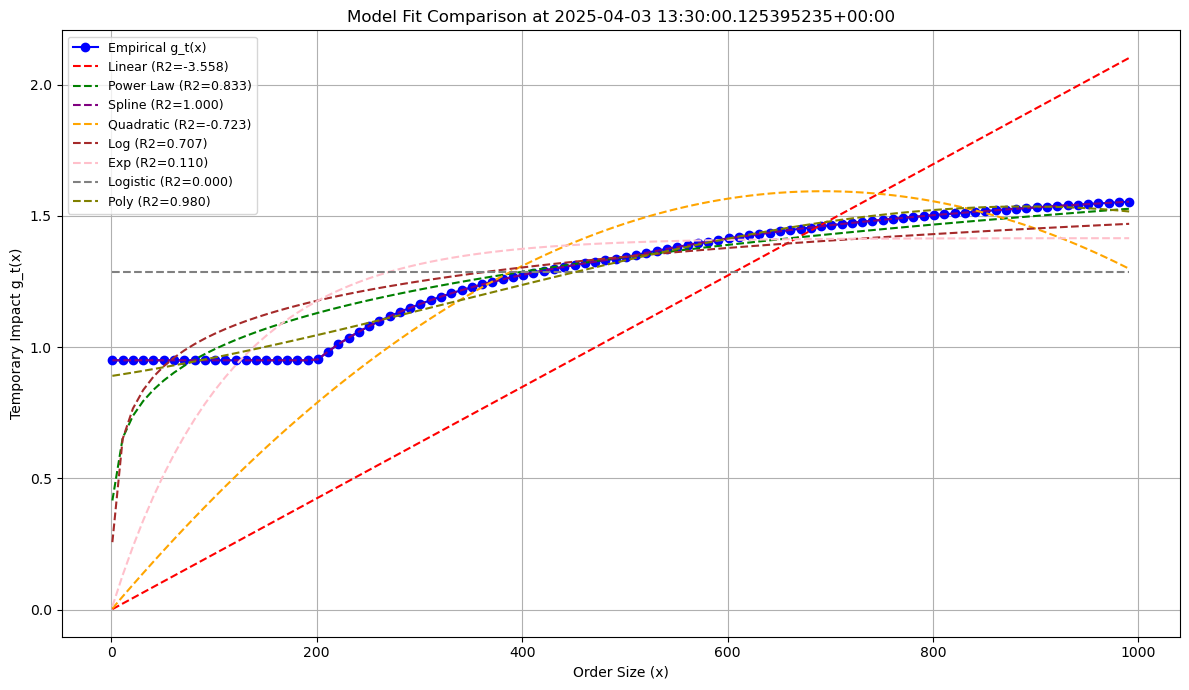

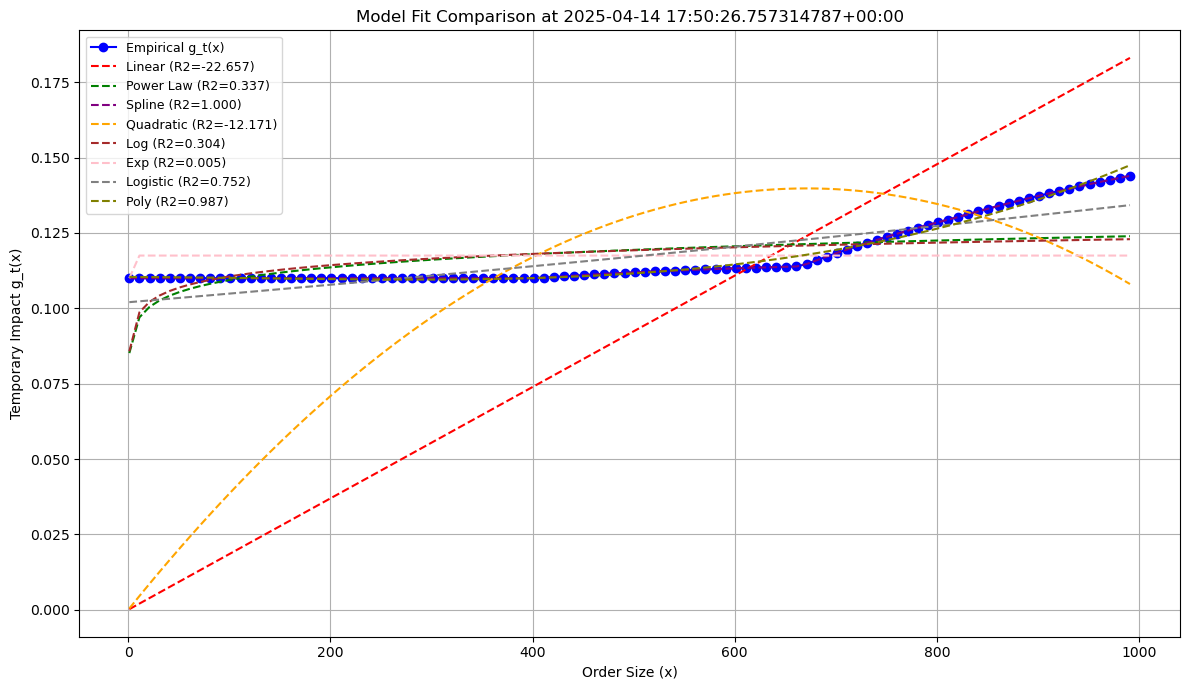

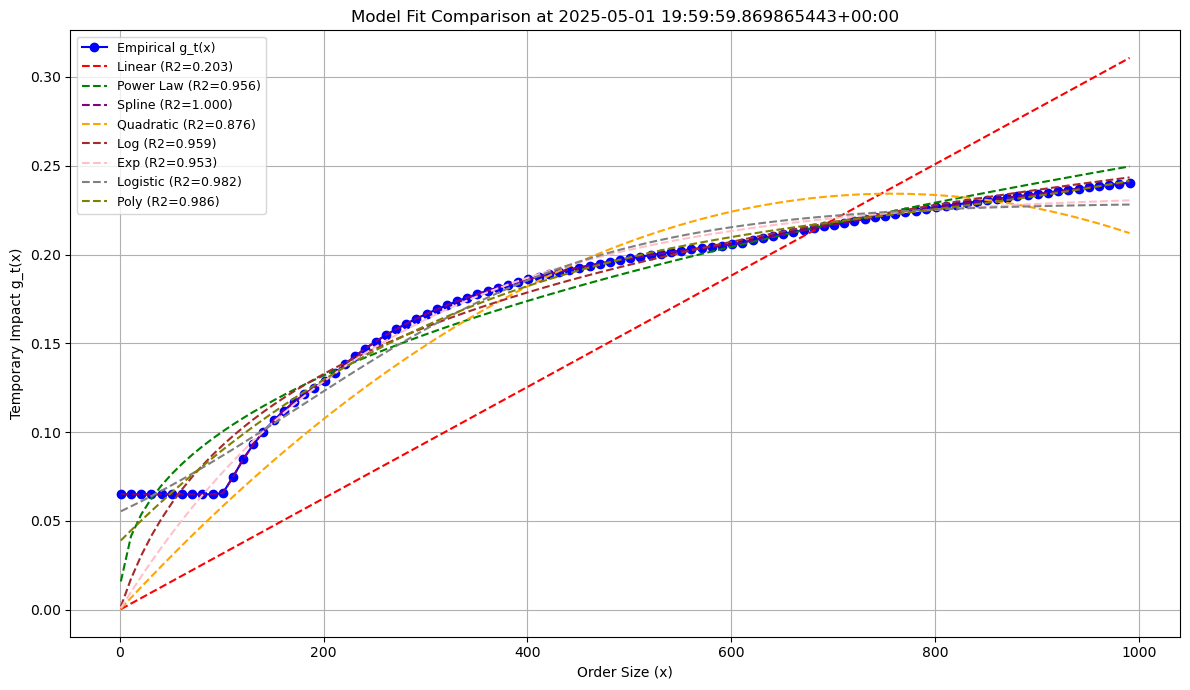

In [21]:
# Select representative timestamps
representative_indices = [0, len(timestamps_valid) // 2, len(timestamps_valid) - 1]

for i in representative_indices:
    idx = valid_indices_all[i]
    row = combined_lob_df.iloc[idx]
    ts = timestamps[idx]

    # Recalculate empirical g_t(x)
    impact_data = []
    for order_size in order_sizes_to_test:
        _, slippage = calculate_slippage(order_size, 'buy', row)
        impact_data.append({'order_size': order_size, 'slippage': slippage})
    
    impact_df = pd.DataFrame(impact_data).dropna()
    x = impact_df['order_size'].values
    y = impact_df['slippage'].values

    # Fit models
    lin_model      = LinearModel().fit(x, y)
    power_model    = PowerLawModel().fit(x, y)
    spline_model   = SplineModel().fit(x, y)
    quad_model     = QuadraticModel().fit(x, y)
    log_model      = LogModel().fit(x, y)
    exp_model      = ExponentialModel().fit(x, y)
    logistic_model = LogisticModel().fit(x, y)
    poly_model     = PolynomialModel(degree=3).fit(x, y)

    # Predictions
    y_lin      = lin_model.predict(x)
    y_power    = power_model.predict(x)
    y_spline   = spline_model.predict(x)
    y_quad     = quad_model.predict(x)
    y_log      = log_model.predict(x)
    y_exp      = exp_model.predict(x)
    y_logistic = logistic_model.predict(x)
    y_poly     = poly_model.predict(x)

    # R^2 Scores
    r2s = {
        'Linear': r2_score(y, y_lin),
        'Power Law': r2_score(y, y_power),
        'Spline': r2_score(y, y_spline),
        'Quadratic': r2_score(y, y_quad),
        'Logarithmic': r2_score(y, y_log),
        'Exponential': r2_score(y, y_exp),
        'Logistic': r2_score(y, y_logistic),
        'Polynomial (Deg 3)': r2_score(y, y_poly),
    }

    # Plot
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, 'o-', label='Empirical g_t(x)', color='blue')
    plt.plot(x, y_lin, '--', label=f'Linear (R2={r2s["Linear"]:.3f})', color='red')
    plt.plot(x, y_power, '--', label=f'Power Law (R2={r2s["Power Law"]:.3f})', color='green')
    plt.plot(x, y_spline, '--', label=f'Spline (R2={r2s["Spline"]:.3f})', color='purple')
    plt.plot(x, y_quad, '--', label=f'Quadratic (R2={r2s["Quadratic"]:.3f})', color='orange')
    plt.plot(x, y_log, '--', label=f'Log (R2={r2s["Logarithmic"]:.3f})', color='brown')
    plt.plot(x, y_exp, '--', label=f'Exp (R2={r2s["Exponential"]:.3f})', color='pink')
    plt.plot(x, y_logistic, '--', label=f'Logistic (R2={r2s["Logistic"]:.3f})', color='gray')
    plt.plot(x, y_poly, '--', label=f'Poly (R2={r2s["Polynomial (Deg 3)"]:.3f})', color='olive')

    plt.xlabel("Order Size (x)")
    plt.ylabel("Temporary Impact g_t(x)")
    plt.title(f"Model Fit Comparison at {ts}")
    plt.legend(fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Inference from Model Fit Comparisons

The three subplots represent model fits for the temporary market impact function gt(x)gt​(x) at three distinct timestamps. Each plot compares multiple parametric models against the empirical impact curve. The visual and numerical trends reveal key insights:
1. Spline Model Consistency
    - In all three snapshots, the Spline model achieves an R2=1.000R2=1.000, indicating a near-perfect fit to the empirical data.
    - This suggests the spline model is highly flexible and captures local variations well.
    - However, splines may overfit and lack smooth extrapolation properties for out-of-sample predictions.

2. Polynomial Model (Degree 3) Robustness
    - The Polynomial model shows high R2R2 values consistently across all three timestamps (≥ 0.98), indicating excellent generalization and capturing of nonlinear trends.
    - It performs nearly as well as the spline model but offers better interpretability and extrapolation control.

3. Power Law and Logistic Models
    - Power law and logistic models perform well in two out of three cases, with R2≥0.75R2≥0.75.
    - They handle nonlinear growth patterns better than linear/log models.
    - Logistic fits can plateau, making them useful for saturated impact modeling.

4. Poor Performance by Linear, Quadratic, and Exponential Models
   - Linear and Quadratic models yield negative or very low R2R2 scores in two out of three snapshots.
   - This suggests they are too simplistic or misrepresent the curvature in the empirical data.
   - Exponential model is unstable across timestamps, failing to capture the flattening or saturation behavior of the market impact.

6. Model Stability Varies Across Time
    - The effectiveness of models like Power Law and Logistic fluctuates with market conditions (as seen from their varying R2R2).
    - Polynomial and Spline models remain consistently strong, making them suitable candidates for general use.

## Evaluate Model Fit Across Multiple Order Sizes for Robustness

In [22]:
# Define multiple representative order sizes
evaluation_sizes = [50, 100, 200, 400, 600, 800, 1000]
multi_size_evaluations = []

for idx in valid_indices_all:
    row = combined_lob_df.iloc[idx]
    timestamp = row['ts_event']

    impact_data = []
    for size in evaluation_sizes:
        _, slippage = calculate_slippage(size, 'buy', row)
        impact_data.append({'order_size': size, 'slippage': slippage})

    impact_df = pd.DataFrame(impact_data).dropna()
    x_eval = impact_df['order_size'].values
    y_eval = impact_df['slippage'].values

    if len(y_eval) < 3:
        continue  # skip if not enough valid points

    # Fit each model and predict over the evaluation sizes
    row_metrics = {'timestamp': timestamp}

    for name, model_class in [
        ('Linear', LinearModel),
        ('PowerLaw', PowerLawModel),
        ('Spline', SplineModel),
        ('Quadratic', QuadraticModel),
        ('Log', LogModel),
        ('Exp', ExponentialModel),
        ('Logistic', LogisticModel),
        ('Poly', PolynomialModel)
    ]:
        try:
            model = model_class().fit(x_eval, y_eval)
            y_pred = model.predict(x_eval)
            metrics = evaluate_model(y_eval, y_pred)
            row_metrics[f'R2_{name}'] = metrics['R2']
            row_metrics[f'RMSE_{name}'] = metrics['RMSE']
            row_metrics[f'MAE_{name}'] = metrics['MAE']
        except:
            row_metrics[f'R2_{name}'] = None
            row_metrics[f'RMSE_{name}'] = None
            row_metrics[f'MAE_{name}'] = None

    multi_size_evaluations.append(row_metrics)

# Combine into DataFrame
multi_size_eval_df = pd.DataFrame(multi_size_evaluations)

# Aggregate metrics across time
mean_multi_size_metrics = multi_size_eval_df.mean(numeric_only=True).round(4)

# Print average metrics
print("\\n=== Aggregated Evaluation Across Multiple Order Sizes ===")
print(mean_multi_size_metrics)

\n=== Aggregated Evaluation Across Multiple Order Sizes ===
R2_Linear        -22.8706
RMSE_Linear        0.0856
MAE_Linear         0.0731
R2_PowerLaw        0.7948
RMSE_PowerLaw      0.0162
MAE_PowerLaw       0.0133
R2_Spline          1.0000
RMSE_Spline        0.0000
MAE_Spline         0.0000
R2_Quadratic     -11.9254
RMSE_Quadratic     0.0615
MAE_Quadratic      0.0511
R2_Log             0.7587
RMSE_Log           0.0184
MAE_Log            0.0150
R2_Exp             0.4847
RMSE_Exp           0.0271
MAE_Exp            0.0226
R2_Logistic        0.7455
RMSE_Logistic      0.0176
MAE_Logistic       0.0154
R2_Poly            0.9903
RMSE_Poly          0.0048
MAE_Poly           0.0038
dtype: float64


### Observations:

| Model       | R²       | RMSE   | MAE   |
|-------------|----------|--------|-------|
| Linear      | -22.8706 | 0.0856 | 0.0731 |
| Power Law   | 0.7948   | 0.0162 | 0.0133 |
| Spline      | 1.0000   | 0.0000 | 0.0000 |
| Quadratic   | -11.9254 | 0.0615 | 0.0511 |
| Log         | 0.7587   | 0.0184 | 0.0150 |
| Exponential | 0.4847   | 0.0271 | 0.0226 |
| Logistic    | 0.7455   | 0.0176 | 0.0154 |
| Polynomial  | 0.9903   | 0.0048 | 0.0038 |

### Insights
- Spline models achieved a perfect fit with $R^2$ = 1.0 and near-zero error; this is expected as splines interpolate all given points.
- Polynomial and Power Law models also performed very well with high $R^2$ and low errors, suggesting they generalize better than purely interpolative approaches.
- Linear and Quadratic models performed poorly, with large negative $R^2$ values, indicating that they fail to capture the nonlinearity in the slippage curves.
- Logistic and Log models struck a balance between simplicity and accuracy, showing good fits with minimal error.

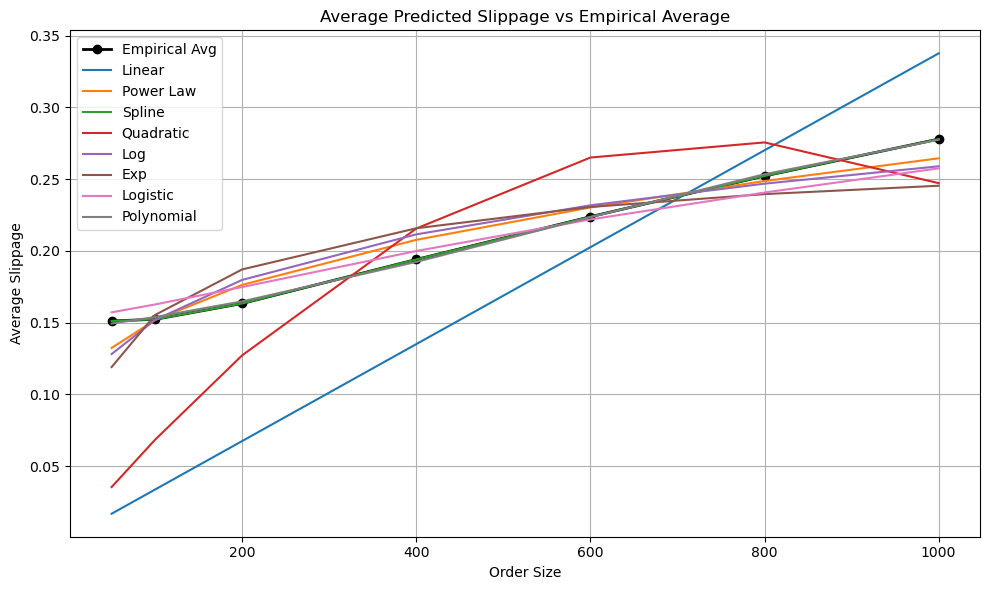

In [23]:
# Define order sizes used for evaluation
evaluation_sizes = [50, 100, 200, 400, 600, 800, 1000]

# Initialize storage for observed and predicted values
empirical_matrix = []
model_predictions = {name: [] for name in [
    'Linear', 'Power Law', 'Spline', 'Quadratic',
    'Log', 'Exp', 'Logistic', 'Polynomial'
]}

# Loop through all valid LOB snapshots
for idx in valid_indices_all:
    row = combined_lob_df.iloc[idx]
    impact_data = []
    for size in evaluation_sizes:
        _, slippage = calculate_slippage(size, 'buy', row)
        impact_data.append(slippage)

    y_true = np.array(impact_data, dtype=np.float64)
    if np.isnan(y_true).sum() > 2:
        continue  # skip if insufficient data

    empirical_matrix.append(y_true)

    x = np.array(evaluation_sizes)
    for name, model_class in [
        ('Linear', LinearModel),
        ('Power Law', PowerLawModel),
        ('Spline', SplineModel),
        ('Quadratic', QuadraticModel),
        ('Log', LogModel),
        ('Exp', ExponentialModel),
        ('Logistic', LogisticModel),
        ('Polynomial', PolynomialModel)
    ]:
        try:
            model = model_class().fit(x, y_true)
            y_pred = model.predict(x)
        except:
            y_pred = np.full_like(x, np.nan, dtype=np.float64)

        model_predictions[name].append(y_pred)

# Convert to arrays
empirical_array = np.array(empirical_matrix)
avg_empirical = np.nanmean(empirical_array, axis=0)

avg_predictions = {
    name: np.nanmean(np.vstack(preds), axis=0)
    for name, preds in model_predictions.items()
    if len(preds) > 0
}

# Plot
plt.figure(figsize=(10, 6))
plt.plot(evaluation_sizes, avg_empirical, 'ko-', label='Empirical Avg', linewidth=2, markersize=6)

for name, avg_pred in avg_predictions.items():
    plt.plot(evaluation_sizes, avg_pred, label=name)

plt.xlabel("Order Size")
plt.ylabel("Average Slippage")
plt.title("Average Predicted Slippage vs Empirical Average")
plt.legend()
plt.grid(True)
plt.tight_layout()

1. Empirical Average Trend
The black line representing empirical average slippage shows a smooth, monotonically increasing relationship with order size as expected; larger orders incur greater slippage. This serves as the benchmark curve.

2. Spline & Polynomial Models
Both Spline and Polynomial models closely track the empirical average across the full range of order sizes. This confirms their excellent fit and generalization ability, making them reliable for modeling real-world impact curves.

3. Power Law and Logistic Models
These models also show strong alignment with the empirical curve, particularly in the mid-to-large order size ranges (200–1000). They balance complexity and generalization well and offer interpretable parametric forms for modeling $g_t(x)$.

4. Linear Model
The Linear model significantly underestimates slippage at small sizes and overestimates it at large sizes, showing a consistent bias. This is expected due to its inability to capture curvature in the impact function.

5. Quadratic Model
The Quadratic model shows non-monotonic behavior beyond 800 units, diverging from the empirical curve and introducing instability. This suggests overfitting or mis-specification, especially at high order sizes.

6. Exponential and Logarithmic Models
These models provide a reasonable approximation but tend to slightly overshoot or undershoot the empirical curve depending on the region. Their simplicity makes them useful, but they lack precision compared to spline/polynomial fits.